In [1003]:
from sklearn.model_selection import train_test_split
from data_loader import DataLoader
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
X_train_full, y_train_full = DataLoader.load_batch('data_batch')
X_test, y_test = DataLoader.load_batch('test_batch', Nbatches=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.15)

Randomly sample `num` images from the arguments, if `y_pred` is provided indicate both the predicted and the actual class name on the image.

In [1004]:
from random import sample
from numpy import ndarray
from matplotlib import pyplot as plt

def display_randomly_sampled_images(num: int, X: ndarray, y_true: ndarray, y_pred: ndarray = None):
	plt.figure(figsize=(num, 5))
	for i, j in enumerate(sample(range(len(X)), num)):
		plt.subplot(1, num, i + 1)
		plt.imshow(X[j])
		plt.axis('off')
		plt.tight_layout(pad=5 / num)
		prediction = ''
		if y_pred is not None:
			prediction += '\nPredicted:\n'
			prediction += class_names[y_pred[j]]
		plt.title(class_names[y_true[j]] + prediction)
	plt.show()

Training Set


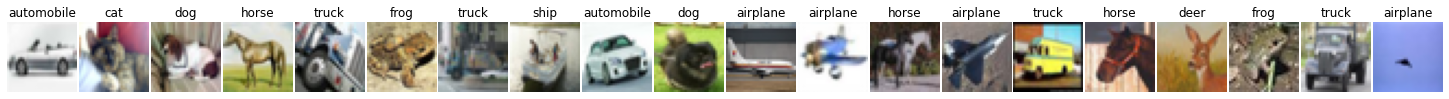

Validation Set


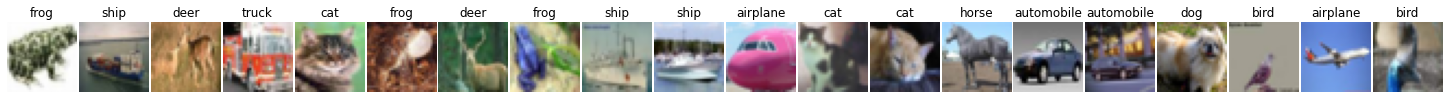

Test Set


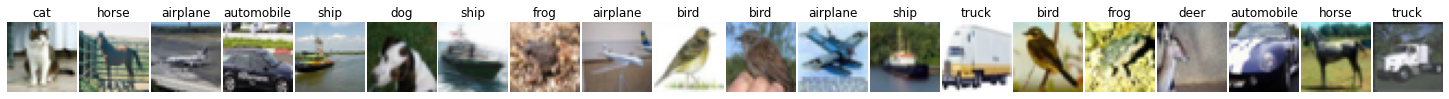

In [1005]:
print('Training Set')
display_randomly_sampled_images(20, X_train, y_train)
print('Validation Set')
display_randomly_sampled_images(20, X_val, y_val)
print('Test Set')
display_randomly_sampled_images(20, X_test, y_test)

Define a function that takes in a `Sequential` model and a learning rate scheduler, returns a record of training and validation loss values and metrics values at successive epochs from the `History` object as well as the compiled and trained model using the learning late scheduler and early stopping with `patience` equals to 10 and `restore_best_weights` set to `True`, so that when the performance no longer improves after `patience` number of epochs training will stop and restore weights from the best epoch in that set.

In [1006]:
from tensorflow.keras import models, layers, callbacks
from typing import Callable
LearningRateScheduler = Callable[[int, float], float]
def train_model(model: models.Sequential, learning_rate_scheduler: LearningRateScheduler):
	learning_rate_scheduler_cb = callbacks.LearningRateScheduler(learning_rate_scheduler)
	early_stopping_cb = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
	model.compile('sgd', 'sparse_categorical_crossentropy', 'accuracy')
	history = model.fit(
		X_train,
		y_train,
		epochs=100,
		validation_data=(X_val, y_val),
		callbacks=[early_stopping_cb, learning_rate_scheduler_cb],
		batch_size=128,
		verbose=0
	)
	return history.history, model

Create a MPL that is parameterised by connection weight initialiser, learning rate scheduler and dropout rate.

In [1007]:
def mlp(kernel_initializer: str, learning_rate_scheduler: LearningRateScheduler, dropout_rate: float):
	return train_model(models.Sequential([
		layers.Flatten(input_shape=X_train.shape[1:], name="input"),
		layers.Dense(1000, activation='relu', name="dense_1", kernel_initializer=kernel_initializer),
		layers.Dropout(dropout_rate, name='dropout_1'),
		layers.Dense(500, activation='relu', name="dense_2", kernel_initializer=kernel_initializer),
		layers.Dropout(dropout_rate, name='dropout_2'),
		layers.Dense(100, activation='relu', name="dense_3", kernel_initializer=kernel_initializer),
		layers.Dropout(dropout_rate, name='dropout_3'),
		layers.Dense(len(class_names), activation='softmax', name="output")
	], name='MLP'), learning_rate_scheduler)

Define 2 learning schedules, `power` and `exponential` scheduling with the same hyperparameter step being 5, `exponential` reduces the learning rate faster than `power` during training where the initial learning rate `lr0` drops by a factor of 10 every 5 steps.

In [1008]:
def power(epoch: int, lr0: float) -> float:
	return lr0 / (1 + epoch / 5)

def exponential(epoch: int, lr0: float) -> float:
	return lr0 * 0.1 ** (epoch / 5)

Use nested for loops to fine tune 3 hyperparameters, this function takes in 3 lists of hyperparameters and returns a dictionary of chosen hyperparameters to the model.

In [1009]:
def grid_search(hyperparameters1, hyperparameters2, hyperparameters3, model: Callable):
	models = {}
	for i in hyperparameters1:
		for j in hyperparameters2:
			for k in hyperparameters3:
				key = f'{i} {j.__name__ if isinstance(j, Callable) else j} {k}'
				models[key] = model(i, j, k)
	return models

Call `grid_search` to get all the models using different hyperparameters. Save the best one based on the maximum `val_accuracy` in the `History` object output from `Model.fit` which is also saved to a `gridsearch.p` pickle file.

In [1010]:
import pickle
NAME = 'Liang_Kaiqi'
def save_best_model(hyperparameters1, hyperparameters2, hyperparameters3, model: Callable):
	folder = f'{NAME}-{model.__name__.upper()}'
	grid_search_res = grid_search(hyperparameters1, hyperparameters2, hyperparameters3, model)

	best_params, (history, best_model) = max(grid_search_res.items(), key=lambda x: max(x[1][0]['val_accuracy']))
	best_model.save(folder)

	with open(f'{folder}/gridsearch.p', 'wb') as fp:
		pickle.dump({best_params: history}, fp)
	return best_model

Create a CNN that is parameterised by kernel size, number of kernels and activation function, these only apply to the first convolutional layer, except for the number of kernels on the second convolutional layer is twice the first one because we want the image to get smaller but deeper as it progresses through the network, and the pooling layer between is shinking the image size.

Use the default kernel initialiser, 0.5 dropout rate and a learning rate scheduler that only starts dropping after 10 epochs as I find that if the learning rate decreases too quickly early stopping won't happen and the CNN will train for the entire 100 epochs because the more epochs the smaller the learning rate gets and when it's too small it doesn't make much of a difference anymore.

In [1011]:
import math
def cnn(kernel_size: int, num_of_kernels: int, activation: str):
	def scheduler(epoch: int, lr: float) -> float:
		if epoch < 10:
			return lr
		else:
			return lr * math.exp(-0.1)
	return train_model(models.Sequential([
		layers.Conv2D(num_of_kernels, kernel_size, activation=activation, padding='same', input_shape=X_train.shape[1:], name='input'),
		layers.MaxPool2D(name='max_pooling'),
		layers.Conv2D(num_of_kernels * 2, 3, activation='relu', padding='same', name='convolution'),
		layers.Flatten(name='flattern'),
		layers.BatchNormalization(name='batch_normalisation'),
		layers.Dense(100, activation='relu', name='dense'),
		layers.Dropout(0.5, name='dropout'),
		layers.Dense(len(class_names), activation='softmax', name='output')
	], name='CNN'), scheduler)

Open the pickle file that stores the grid search results of the training and validation loss and accuracy for all the hyperparameter tuning and show the learning curve plot.

Load the saved model and time it for training 1 epoch by setting `initial_epoch` to the number of epochs it has been trained for.

Estimate the overall computation time by multiplying the time it takes to train 1 epoch by the number of epochs.

In [1012]:
import time
import pandas as pd
def load_best_model(model_name: str):
	folder = f'{NAME}-{model_name}'
	with open(f'{folder}/gridsearch.p', 'rb') as fp:
		history = pickle.load(fp)
		[(best_params, values)] = history.items()

		df = pd.DataFrame(values)
		epochs = len(df)

		model = models.load_model(f'{folder}')
		start = time.time()
		history = model.fit(X_train, y_train, initial_epoch=epochs, epochs=epochs + 1)
		end = time.time()

		time_per_epoch = end - start
		computation_time = epochs * time_per_epoch

		plt.figure(figsize=(5, 15))
		plt.subplot(311)
		plt.title('loss')
		df[['loss', 'val_loss']].plot(ax=plt.gca())

		plt.subplot(312)
		plt.title('accuracy')
		df[['accuracy', 'val_accuracy']].plot(ax=plt.gca())

		plt.subplot(313)
		plt.title('learning rate')
		df['lr'].plot(ax=plt.gca())

		print(f'\nTime it takes to train for 1 epoch: {round(time_per_epoch, 2)} seconds')
		print(f'Number of epochs: {epochs}')
		print(f'Approximate computation time to train the model with the best hyperparameters: {round(computation_time, 2)} seconds')
		print(f'\nBest parameters for {model_name}')
		return model, best_params.split()

Check if the directories of the saved models exist, if not grid search for the best hyperparamesters, otherwise load the models and train for 1 epoch and visualise the learing curve plot for each grid search model.

In [1013]:
from os import path
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

The hyperparameters picked for grid search MLP are `he_normal` and `glorot_uniform` for connection weight initialisation.

Epoch 26/26
1329/1329 [==============================] - 7s 5ms/step - loss: 1.7119 - accuracy: 0.3951

Time it takes to train for 1 epoch: 7.25 seconds
Number of epochs: 25
Approximate computation time to train the model with the best hyperparameters: 181.35 seconds

Best parameters for MLP
kernel initializer: he_normal
learning rate scheduler: power
dropout rate: 0.1


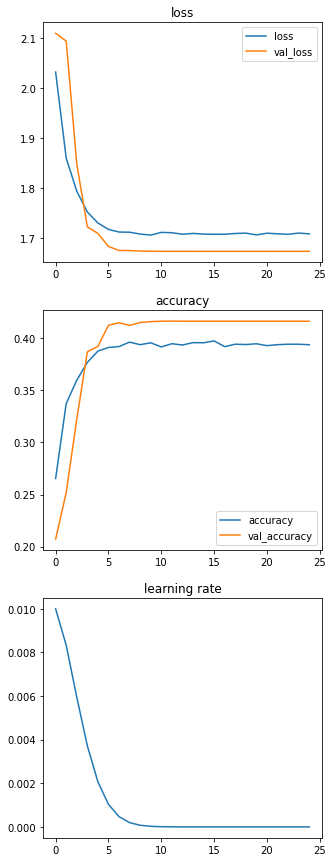

In [1014]:
mlp_model: models.Sequential = None
if path.isdir(f'{NAME}-MLP'):
	mlp_model, (kernel_initializer, learning_rate_scheduler, dropout_rate) = load_best_model('MLP')
	print(f'kernel initializer: {kernel_initializer}')
	print(f'learning rate scheduler: {learning_rate_scheduler}')
	print(f'dropout rate: {dropout_rate}')
else:
	mlp_model = save_best_model(
		['he_normal', 'glorot_uniform'],
		[power, exponential],
		[0.1, 0.3],
		mlp
	)

Epoch 65/65
1329/1329 [==============================] - 34s 26ms/step - loss: 0.5324 - accuracy: 0.8237

Time it takes to train for 1 epoch: 34.08 seconds
Number of epochs: 64
Approximate computation time to train the model with the best hyperparameters: 2181.37 seconds

Best parameters for CNN
kernel size: 5
number of kernels: 64
activation function: selu


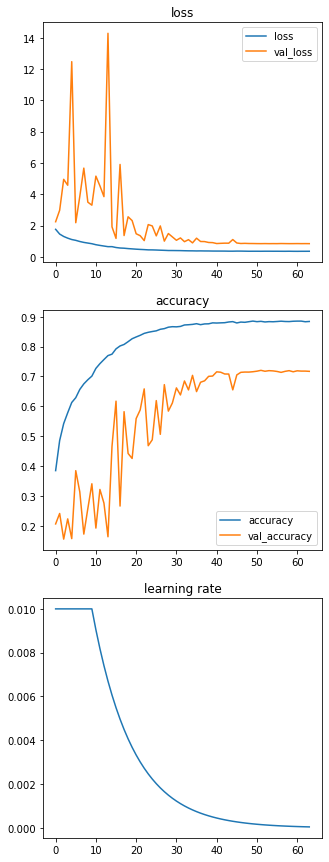

In [1015]:
cnn_model: models.Sequential = None
if path.isdir(f'{NAME}-CNN'):
	cnn_model, (kernel_size, num_kernels, activation_function) = load_best_model('CNN')
	print(f'kernel size: {kernel_size}')
	print(f'number of kernels: {num_kernels}')
	print(f'activation function: {activation_function}')
else:
	cnn_model = save_best_model(
		[5, 7],
		[32, 64],
		['relu', 'selu'],
		cnn
	)

In [1016]:
mlp_model.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 3072)              0         
                                                                 
 dense_1 (Dense)             (None, 1000)              3073000   
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 500)               500500    
                                                                 
 dropout_2 (Dropout)         (None, 500)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               50100     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0       

In [1017]:
cnn_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 32, 32, 64)        4864      
                                                                 
 max_pooling (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 convolution (Conv2D)        (None, 16, 16, 128)       73856     
                                                                 
 flattern (Flatten)          (None, 32768)             0         
                                                                 
 batch_normalisation (BatchN  (None, 32768)            131072    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 100)               3276900   
                                                               

In [1018]:
from sklearn import metrics
import numpy as np
def report(model: models.Sequential):
	y_pred = np.argmax(model.predict(X_test), axis=-1)
	correct = np.where(np.equal(y_pred, y_test) == True)[0]
	failure = np.where(np.equal(y_pred, y_test) == False)[0]
	display_randomly_sampled_images(5, X_test[correct], y_test[correct], y_pred[correct])
	display_randomly_sampled_images(5, X_test[failure], y_test[failure], y_pred[failure])
	confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
	metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=class_names).plot()
	fig = plt.gcf()
	fig.set_size_inches(15, 15)
	fig.suptitle(model.name)
	plt.show()
	print(metrics.classification_report(y_test, y_pred, target_names=class_names))

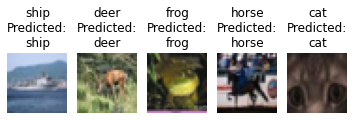

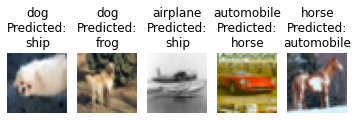

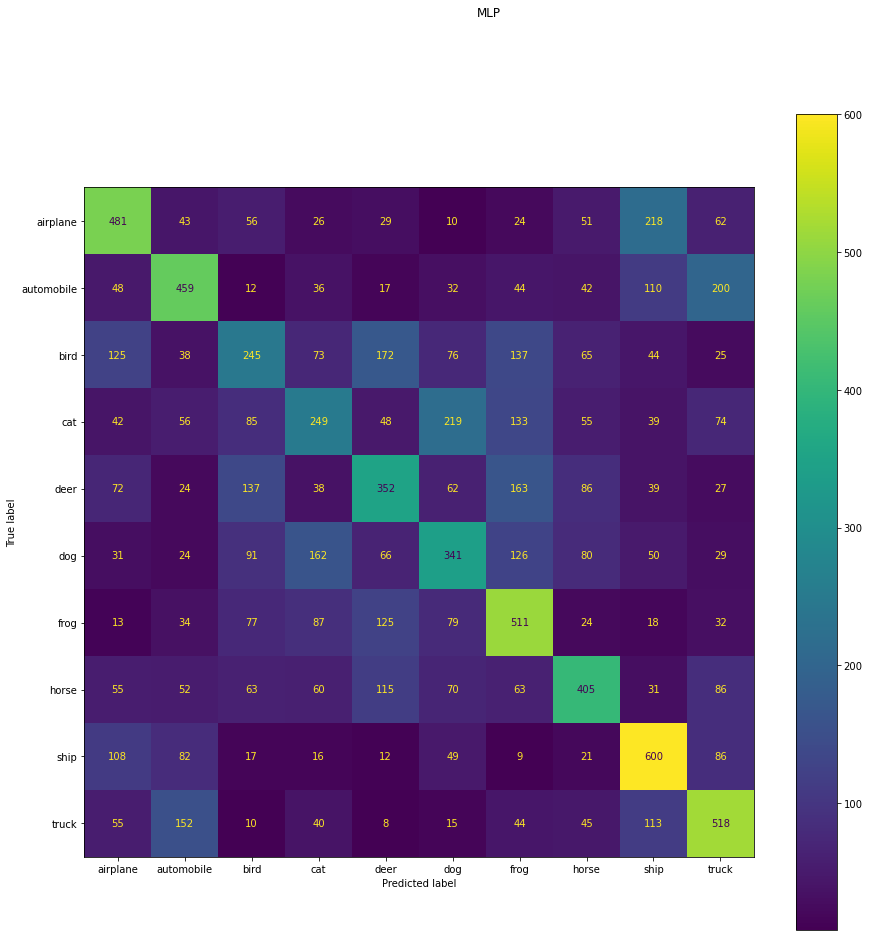

              precision    recall  f1-score   support

    airplane       0.47      0.48      0.47      1000
  automobile       0.48      0.46      0.47      1000
        bird       0.31      0.24      0.27      1000
         cat       0.32      0.25      0.28      1000
        deer       0.37      0.35      0.36      1000
         dog       0.36      0.34      0.35      1000
        frog       0.41      0.51      0.45      1000
       horse       0.46      0.41      0.43      1000
        ship       0.48      0.60      0.53      1000
       truck       0.45      0.52      0.48      1000

    accuracy                           0.42     10000
   macro avg       0.41      0.42      0.41     10000
weighted avg       0.41      0.42      0.41     10000



In [1019]:
report(mlp_model)

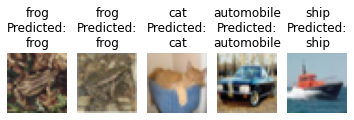

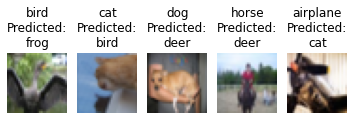

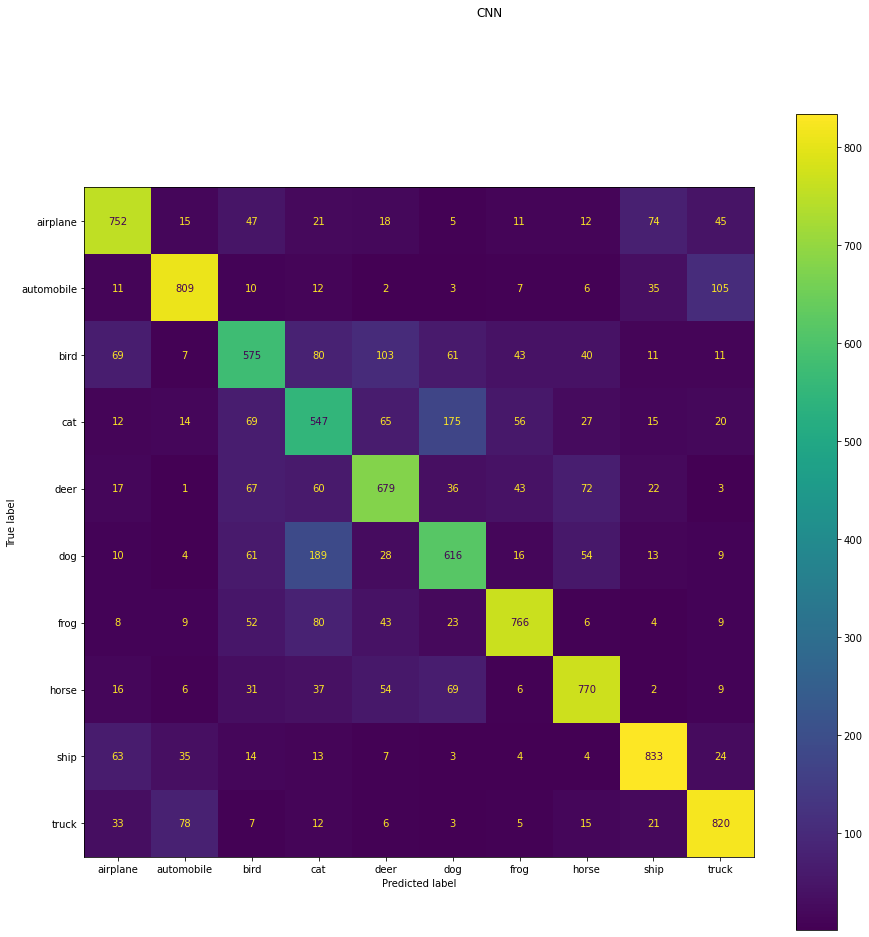

              precision    recall  f1-score   support

    airplane       0.76      0.75      0.76      1000
  automobile       0.83      0.81      0.82      1000
        bird       0.62      0.57      0.59      1000
         cat       0.52      0.55      0.53      1000
        deer       0.68      0.68      0.68      1000
         dog       0.62      0.62      0.62      1000
        frog       0.80      0.77      0.78      1000
       horse       0.77      0.77      0.77      1000
        ship       0.81      0.83      0.82      1000
       truck       0.78      0.82      0.80      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



In [1020]:
report(cnn_model)